# Часть 1. Проверка гипотезы в Python и составление аналитической записки

## Анализ различий в пользовательской активности между городами: Санкт-Петербург и Москва

- Автор: Стефашова Людмила
- Дата: 18.10.2025

## Цели и задачи проекта

*Основная цель проекта:* 

статистически проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы.

*Формулировка гипотезы:*

пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

- Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

*Задачи проекта:*

- Провести предобработку данных, включая проверку на дубликаты идентификаторов пользователей
- Выполнить сравнительный анализ размеров групп и их статистических характеристик
- Провести статистическую проверку гипотезы с использованием t-теста
- Сформулировать выводы на основе полученных результатов
- Предложить возможные объяснения выявленных закономерностей

## Описание данных

Таблица с пользователями `yandex_knigi_data.csv`

- `city` — город проживания пользователя.

- `puid` — уникальный идентификатор пользователя.

- `hours` — время активности пользователя в приложении.


## Содержимое проекта

- Загрузка и предобработка данных
- Проверка на дубликаты
- Описательный анализ
- Проведение t-теста
- Формулировка выводов
- Подготовка итогового отчета


## Загрузка данных и знакомство с ними

Загружаем данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Выгружаем данные в датафрейм
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
# Выводим первые строки датафрейма на экран
df.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Удаляем столбец, который полностью дублирует индекс
df = df.drop(columns=['Unnamed: 0'])

In [5]:
# Выводим первые строки датафрейма на экран
df.head()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [6]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


*Структура данных:*

- Тип данных: pandas DataFrame
- Общее количество записей: 8784
- Состав датасета Количество столбцов: 4

*Описание столбцов:*

- `Unnamed:` 0 - целочисленные значения (int64), 8784 непустых записей
- `city` - категориальный признак (object), 8784 непустых записей
- `puid` - уникальный идентификатор пользователя (int64), 8784 непустых записей
- `hours` - время активности пользователя в часах (float64), 8784 непустых записи

*Качество данных*

- В датасете отсутствуют пропущенные значения во всех столбцах
- Все записи имеют корректные типы данных
- Каждый столбец полностью заполнен данными

Проверим данные на дубликаты

In [7]:
# Считаем уникальные значеня в столбце puid
unique_puid_count = df['puid'].nunique()
total_records = df.shape[0]

print(f"Общее количество записей: {total_records}")
print(f"Количество уникальных puid: {unique_puid_count}")
print(f"Количество дубликатов puid: {total_records - unique_puid_count}")

Общее количество записей: 8784
Количество уникальных puid: 8540
Количество дубликатов puid: 244


In [8]:
# Считаем количество вхождений каждого puid
puid_counts = df['puid'].value_counts()
duplicate_analysis = puid_counts[puid_counts > 1]

# Выводим статистику по дубликатам
print("Распределение дубликатов:")
print(duplicate_analysis.value_counts())

Распределение дубликатов:
count
2    244
Name: count, dtype: int64


Поскольку каждый пользователь должен быть представлен один раз в анализе (иначе мы исказим среднее время активности), необходимо оставить только одну запись на каждого пользователя.
Удаляем дубликаты по `puid`, оставив первое вхождение.

In [9]:
# Удаляем дубликаты по puid, оставляя первую запись
df_clean = df.drop_duplicates(subset='puid', keep='first')

# Проверяем результат
print(f"Записей после удаления дубликатов: {df_clean.shape[0]}")
print(f"Уникальных puid: {df_clean['puid'].nunique()}")

Записей после удаления дубликатов: 8540
Уникальных puid: 8540


Дубликаты удалены.

Теперь сравним размеры групп (сколько пользователей из Москвы, сколько из СПб).

Посчитаем основные статистики по времени активности `hours` в каждом городе.

In [10]:
# Считаем размеры групп
group_sizes = df_clean['city'].value_counts()
print("Размеры групп:")
print(group_sizes)
print()
# Выводим статистические данные
moscow_stats = df[df['city'] == 'Москва']['hours'].describe()
print("Статистика для Москвы:")
print(moscow_stats)
spb_stats = df[df['city'] == 'Санкт-Петербург']['hours'].describe()
print("Статистика для Санкт-Петербурга:")
print(spb_stats)

Размеры групп:
city
Москва             6234
Санкт-Петербург    2306
Name: count, dtype: int64

Статистика для Москвы:
count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64
Статистика для Санкт-Петербурга:
count    2550.000000
mean       11.592691
std        39.704993
min         0.000025
25%         0.080002
50%         0.984781
75%         6.509072
max       978.764775
Name: hours, dtype: float64


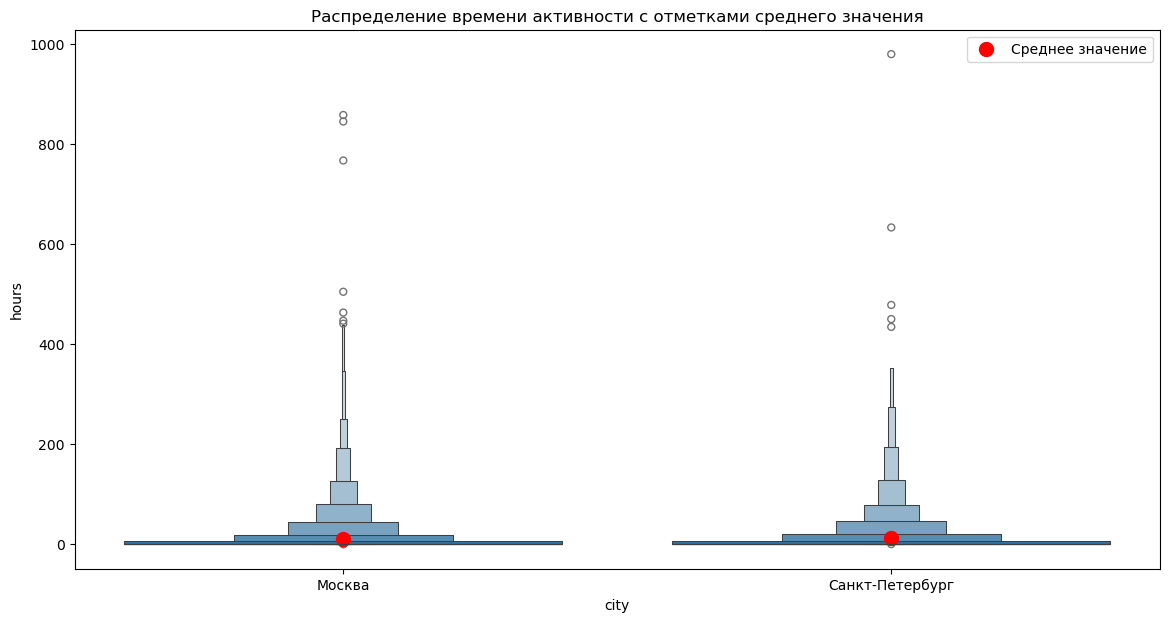

In [11]:
# Строим ящик с усами
plt.figure(figsize=(14, 7))
sns.boxenplot(x='city', y='hours', data=df)
plt.scatter(
    x=[0, 1],
    y=[
        df[df['city'] == 'Москва']['hours'].mean(),
        df[df['city'] == 'Санкт-Петербург']['hours'].mean()
    ],
    color='red',
    marker='o',
    s=100,
    label='Среднее значение'
)
plt.title('Распределение времени активности с отметками среднего значения')
plt.legend()
plt.show()

*Наблюдения:*

Среднее время в СПб действительно выше, чем в Москве:
- 11.26 > 10.88
- разница = +0.38 часа (~23 минуты).

Разброс очень большой:

- Стандартное отклонение в 3–4 раза превышает среднее.
- Медиана (~0.9 ч) гораздо ниже среднего, распределение сильно смещено вправо (многие пользователи почти не используют приложение, но есть "тяжелые пользователи", которые сильно увеличивают среднее).

Группы неравные:

- Москва: 6234
- СПб: 2306

Но обе выборки достаточно большие (>1000), поэтому центральная предельная теорема позволяет применять t-тест даже при ненормальности.

## Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [12]:
# Устанавливаем уровень значимости
alpha = 0.05

# Создаем отдельные выборки
spb_hours = df[df['city'] == 'Санкт-Петербург']['hours']
mos_hours = df[df['city'] == 'Москва']['hours']

# Применяем тест Манна-Уитни
mw_test = mannwhitneyu(
    spb_hours,
    mos_hours,
    alternative='greater'  # односторонний тест, так как по альтернативной гипотезе в СПб время больше
)

# Интерпретация результатов
if mw_test.pvalue > alpha:
    print(f'p-value теста Манна — Уитни = {round(mw_test.pvalue, 4)}')
    print('Нулевая гипотеза находит подтверждение! Статистически значимых различий в распределении времени активности между группами нет')   
else:
    print(f'p-value теста Манна — Уитни = {round(mw_test.pvalue, 4)}')
    print('Нулевая гипотеза находит подтверждение! Распределение времени активности в группе Санкт-Петербурга статистически значимо выше')
    

p-value теста Манна — Уитни = 0.0891
Нулевая гипотеза находит подтверждение! Статистически значимых различий в распределении времени активности между группами нет


## Аналитическая записка

**Тема: Проверка гипотезы о различии среднего времени активности пользователей в приложении между Санкт-Петербургом и Москвой**

**Цель исследования:**

Проверка гипотезы о том, что пользователи из Санкт-Петербурга проводят больше времени в приложении по сравнению с пользователями из Москвы.

**Методология исследования**

*Статистический метод:*

- Тест Манна-Уитни — непараметрический критерий для сравнения двух независимых выборок
- Односторонний тест — проверка гипотезы о превышении среднего значения в группе Санкт-Петербурга
- Уровень значимости: α = 0.05

**Результаты анализа**

*Исходные данные:*

- Группа Москва: 6234 пользователя
- Группа Санкт-Петербург: 2306 пользователей

*Статистические показатели:*

- Среднее время активности (Москва): 10.88 часов
- Среднее время активности (Санкт-Петербург): 11.59 часов
- p-value теста Манна-Уитни: 0.0891


**Интерпретация результатов**

*Статистический вывод:*

- Полученное значение p-value (0.0891) > α (0.05)
- Нулевая гипотеза о равенстве распределений не отвергается
- Статистически значимых различий в распределении времени активности между группами не обнаружено

**Вывод:**

Нет статистически значимых доказательств того, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы. Наблюдаемая разница в средних (11.26 ч против 10.88 ч) может быть обусловлена случайной вариацией. 

**Возможные объяснения результатов**

*Особенности выборки:*

- Наличие значительного количества пользователей с низкой активностью в обеих группах
- Выбросы в данных могли повлиять на общую картину
- Разный размер групп мог снизить мощность теста

**Заключение**

Гипотеза о том, что пользователи из Санкт-Петербурга проводят больше времени в приложении, не подтверждена статистически. Рекомендуется использовать более устойчивые метрики (например, медиану или долю активных пользователей) для дальнейшего анализа региональных различий.

----

# Часть 2. Анализ результатов A/B-тестирования

## Цели исследования.



К нам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.


**Цели исследования**

*Основная цель:*

- Оценить эффективность новой версии сайта интернет-магазина BitMotion Kit
- Определить, приводит ли обновленный интерфейс к увеличению конверсии в покупку

*Конкретные задачи:*

- Проверить корректность проведения A/B-теста
- Проанализировать поведение пользователей в контрольной и тестовой группах
- Оценить статистическую значимость полученных результатов
- Сформулировать рекомендации по внедрению изменений

**Предпосылки проведения исследования**

*Исходная проблема:*

- Сложность интерфейса для пользователей
- Необходимость привлечения новых клиентов
- Потребность в увеличении продаж

*Ожидаемый результат:*

- Упрощение пользовательского опыта
- Рост конверсии в покупку
- Расширение целевой аудитории

**Методология исследования**

*Тип исследования:*

- A/B-тест с разделением пользователей на две группы:
    - Контрольная группа (текущая версия сайта)
    - Тестовая группа (обновленная версия сайта)

*Ключевая метрика:*

- Конверсия в покупку

**План анализа**

*Этапы анализа:*

- Проверка корректности распределения пользователей по группам
- Анализ основных метрик в группах
- Статистическая проверка гипотез
- Оценка эффекта от изменений
- Формулировка выводов и рекомендаций

## Загрузка данных, оценка их целостности.


In [13]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [14]:
# Выводим инфомацию из таблицы ab_test_participants.csv
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [15]:
# Выводим первые строки из таблицы ab_test_participants.csv
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


Таблица `participants` - таблица участников тестов

Всего записей 14 525

*Столбцы:*
- `user_id` — идентификатор пользователя
- `group` — группа пользователя
- `ab_tes` — название теста
- `device` — устройство, с которого происходила регистрация

*Качество данных*

- В датасете отсутствуют пропущенные значения во всех столбцах
- Все записи имеют корректные типы данных
- Каждый столбец полностью заполнен данными

In [16]:
# Проверим наличие дубликатов
# Считаем общее количество записей и количество уникальных user_id
total_participants = participants.shape[0]
unique_users = participants['user_id'].nunique()

print(f"Всего записей в participants: {total_participants}")
print(f"Уникальных user_id: {unique_users}")
print(f"Дубликатов user_id: {total_participants - unique_users}")

Всего записей в participants: 14525
Уникальных user_id: 13638
Дубликатов user_id: 887


In [17]:
# Выводим уникальные названия тестов
participants['ab_test'].unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

In [18]:
# Оставляем только участников теста интерфейса
ab_test_participants = participants[participants['ab_test'] == 'interface_eu_test']

# Теперь проверяем дубликаты в рамках одного теста
total = ab_test_participants.shape[0]
unique_users = ab_test_participants['user_id'].nunique()
duplicates = total - unique_users

print(f"Записей в ab_test_participants: {total}")
print(f"Уникальных пользователей: {unique_users}")
print(f"Дубликатов user_id в рамках одного теста: {duplicates}")

Записей в ab_test_participants: 10850
Уникальных пользователей: 10850
Дубликатов user_id в рамках одного теста: 0


Мы обнаружили 887 пользователей, участвующих одновременно в:
- interface_eu_test (тест интерфейса),
- recommender_system_test (конкурирующий тест рекомендаций).

Это составляет: ≈8.2%

*Проблема:*

- Такое пересечение нарушает изоляцию тестируемого эффекта.
- Пользователи в пересечении подвергались двум изменениям одновременно:
    - Новый интерфейс
    - Новая система рекомендаций.
- Это создаёт риск взаимодействия эффектов:
    - Например, новый интерфейс может лучше работать только с новыми рекомендациями, и наоборот.
    - В результате невозможно отделить, что именно повлияло на поведение пользователя.

*Вывод:*

- Наличие 887 (8.2%) пользователей в обоих тестах — существенное нарушение принципа изоляции в A/B-тестировании. 

*Рекомендации:*

- Исключить 887 пересекающихся пользователей из анализа, чтобы оценить эффект интерфейса в чистом виде

In [19]:
# Выводим информацию о таблице ab_test_events
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [20]:
# Выводим первые строки из таблицы ab_test_events
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Таблица `events` - архив с одним csv-файлом, в котором собраны события 2020 года

Всего 787 286 событий

*Столбцы:*

- `user_id` — идентификатор пользователя. Не содержит пропуски.
- `event_dt` — дата и время события. Не содержит пропуски.
- `event_name` — тип события. Не содержит пропуски.
- `details` — дополнительные данные о событии. 
    - Заполнено только в 249 022 из 787 286 строк. Много пропусков, но это нормально. Разные типы событий требуют разной информации:
        - События просмотра (product_page) не требуют дополнительных данных
        - Действия авторизации (login) не содержат числовых значений
        - Только определенные события (registration, purchase) имеют стоимость

**Важное наблюдение:**

в `user_id` есть значение "GLOBAL" — это не пользователь, а, скорее всего, системное событие (например, показ рекламы, общая аналитика). Такие записи нужно исключить из анализа поведения пользователей.

In [21]:
# Оставляем только реальных пользователей
events_clean = events[events['user_id'] != 'GLOBAL']

In [22]:
# Выводим информацию по очищенной таблице
events_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728791 entries, 1 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     728791 non-null  object        
 1   event_dt    728791 non-null  datetime64[ns]
 2   event_name  728791 non-null  object        
 3   details     233499 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 27.8+ MB


## Оценка корректности проведения теста по таблице `ab_test_participants`:

   3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

Чтобы обеспечить чистоту анализа, исключаем всех пользователей, участвующих одновременно в двух тестах (interface_eu_test и recommender_system_test). Это гарантирует, что эффект новой версии интерфейса оценивается без влияния других изменений.

In [23]:
# Определяем пользователей в целевом тесте (interface_eu_test)
users_interface = set(participants[participants['ab_test'] == 'interface_eu_test']['user_id'])

# Определяем пользователей в конкурирующем тесте (recommender_system_test)
users_other = set(participants[participants['ab_test'] == 'recommender_system_test']['user_id'])

# Находим пересечение
users_in_both = users_interface & users_other
print(f"Пользователей, участвующих в обоих тестах: {len(users_in_both)}")

Пользователей, участвующих в обоих тестах: 887


In [24]:
# Берём всех участников целевого теста
clean_interface = participants[participants['ab_test'] == 'interface_eu_test'].copy()

# Исключаем пересекающихся пользователей
clean_interface = clean_interface[~clean_interface['user_id'].isin(users_in_both)]

# Выводим результат
print(f"\nПосле очистки: {clean_interface.shape[0]} пользователей")
print("Распределение по группам:")
print(clean_interface['group'].value_counts())


После очистки: 9963 пользователей
Распределение по группам:
group
B    5011
A    4952
Name: count, dtype: int64


In [25]:
clean_interface.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9963 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  9963 non-null   object
 1   group    9963 non-null   object
 2   ab_test  9963 non-null   object
 3   device   9963 non-null   object
dtypes: object(4)
memory usage: 389.2+ KB


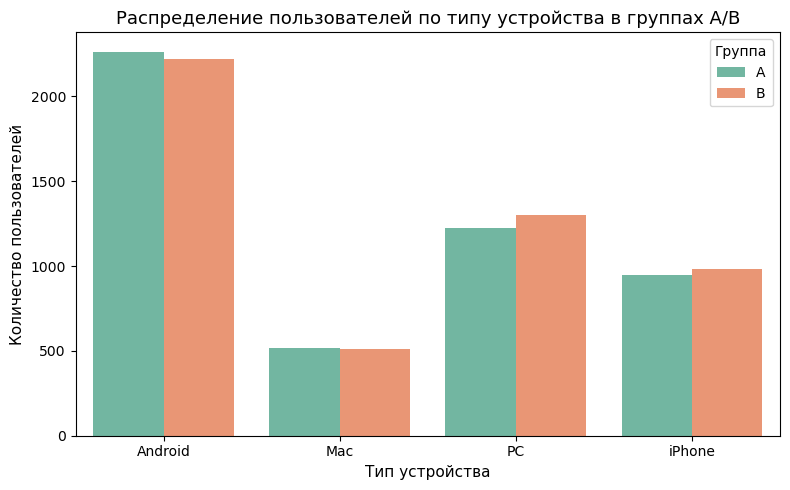

In [26]:
# Подготовим данные: посчитаем количество пользователей по группе и устройству
device_counts = clean_interface.groupby(['group', 'device']).size().reset_index(name='count')

# Строим столбчатую диаграммы
plt.figure(figsize=(8, 5))
sns.barplot(data=device_counts, x='device', y='count', hue='group', palette='Set2')

# Оформляем
plt.title('Распределение пользователей по типу устройства в группах A/B', fontsize=13)
plt.xlabel('Тип устройства', fontsize=11)
plt.ylabel('Количество пользователей', fontsize=11)
plt.legend(title='Группа')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

В ходе анализа таблицы ab_test_participants была проведена проверка ключевых условий корректности A/B-теста, направленного на оценку влияния новой версии интерфейса на конверсию в покупку.

**Соответствие требованиям технического задания**

Из общей таблицы участников, содержащей данные по двум A/B-тестам (interface_eu_test и recommender_system_test), была корректно выделена подвыборка только по целевому тесту — interface_eu_test.

**Равномерность распределения по группам**

После очистки данных распределение участников по группам следующее:

- Группа A (контроль): 4 952 пользователя (49.7%)
- Группа B (тест): 5 011 пользователей (50.3%)

Разница составляет всего 0.6 процентных пункта, что соответствует параметрам A/B-тестирования и гарантирует сопоставимость групп.

**Отсутствие пересечений с конкурирующим тестом**

Изначально нарушено, но устранено в ходе анализа.
Было выявлено, что 887 пользователей (8.2% от исходной выборки) участвовали одновременно в двух тестах:

- interface_eu_test (интерфейс)
- recommender_system_test (рекомендательная система)

Это создавало риск смешения эффектов, так как поведение таких пользователей могло быть обусловлено не только новым интерфейсом, но и изменениями в рекомендациях.

Для обеспечения чистоты эксперимента все 887 пересекающихся пользователей были исключены из анализа.
Итоговая выборка содержит 9 963 уникальных пользователя, каждый из которых участвовал только в одном тесте — interface_eu_test.

**Баланс по категориальным признакам: распределение по типам устройств**

Анализ показал, что распределение пользователей по типу устройства (device) между группами A и B статистически одинаково.
График распределения по устройствам наглядно демонстрирует равномерность: столбцы для групп A и B в каждой категории устройств имеют почти одинаковую высоту, что говорит о корректной рандомизации. 

**Заключение**

После проведения очистки данных A/B-тест interface_eu_test можно считать корректно организованным:

- Выборка соответствует ТЗ
- Группы сбалансированы
- Отсутствуют пересечения с другими тестами
- Распределение по ключевым характеристикам (тип устройства) — равномерное

Таким образом, условия для объективной оценки эффекта новой версии интерфейса выполнены, и дальнейший анализ конверсии на этой выборке будет статистически обоснованным и достоверным.

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставим только события, связанные с участвующими в изучаемом тесте пользователями;

In [27]:
# Объединяем датасеты по левому присоединению, чтобы получить всех пользоватетей из таблицы clean_interface
events_filtered = clean_interface.merge(events_clean, on='user_id', how='left')
events_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73815 entries, 0 to 73814
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     73815 non-null  object        
 1   group       73815 non-null  object        
 2   ab_test     73815 non-null  object        
 3   device      73815 non-null  object        
 4   event_dt    73815 non-null  datetime64[ns]
 5   event_name  73815 non-null  object        
 6   details     19450 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 3.9+ MB


- определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [28]:
# Выделяем события регистрации
registration_events = events_filtered[events_filtered['event_name'] == 'registration']

# Создаём таблицу: user_id -> дата регистрации
registration_dates = registration_events.groupby('user_id')['event_dt'].min().reset_index()
registration_dates.rename(columns={'event_dt': 'registration_dt'}, inplace=True)

print(f"Найдено дат регистрации для {registration_dates.shape[0]} пользователей")

Найдено дат регистрации для 9963 пользователей


In [29]:
# Объединяем все события с датой регистрации
events_with_reg = events_filtered.merge(registration_dates, on='user_id', how='left')

# Проверяем, у всех ли есть регистрация
missing_reg = events_with_reg['registration_dt'].isna().sum()
print(f"Событий без даты регистрации: {missing_reg}")

Событий без даты регистрации: 0


In [30]:
# Рассчитываем разницу в днях
events_with_reg['days_since_registration'] = (
    (events_with_reg['event_dt'] - events_with_reg['registration_dt']).dt.total_seconds() / (60 * 60 * 24)
)

# Оставляем только события в первые 7 дней
events_7d = events_with_reg[events_with_reg['days_since_registration'] <= 7]

print(f"Событий в первые 7 дней: {events_7d.shape[0]}")
print(f"Пользователей с событиями в первые 7 дней: {events_7d['user_id'].nunique()}")

Событий в первые 7 дней: 63805
Пользователей с событиями в первые 7 дней: 9963


In [31]:
events_7d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63805 entries, 0 to 73814
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  63805 non-null  object        
 1   group                    63805 non-null  object        
 2   ab_test                  63805 non-null  object        
 3   device                   63805 non-null  object        
 4   event_dt                 63805 non-null  datetime64[ns]
 5   event_name               63805 non-null  object        
 6   details                  16125 non-null  object        
 7   registration_dt          63805 non-null  datetime64[ns]
 8   days_since_registration  63805 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 4.9+ MB


Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. 

Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [32]:
# Зафиксируем значения для расчёта достаточности выборки
baseline_conversion_rate = 0.30  # Базовая конверсия — 30%
mde = 0.10                       # Минимально детектируемый эффект — 10% относительного роста
alpha = 0.05                     # Уровень значимости — 5% (достоверность 95%)
power = 0.80                     # Мощность — 80%

# Рассчитаем ожидаемую конверсию в тестовой группе
new_conversion_rate = baseline_conversion_rate * (1 + mde)

# Вычислим размер эффекта
effect_size = proportion_effectsize(baseline_conversion_rate, new_conversion_rate)

# Инициализируем анализ мощности
power_analysis = NormalIndPower()

# Рассчитаем необходимый размер выборки **на одну группу**
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio=1.0  
)

# Общий размер выборки (обе группы)
total_sample_size = sample_size * 2

# Выведем результаты
print(f"\nМинимальный размер выборки для каждой группы: {int(np.ceil(sample_size))}")
print(f"Общий минимальный размер выборки (A + B): {int(np.ceil(total_sample_size))}")


Минимальный размер выборки для каждой группы: 3762
Общий минимальный размер выборки (A + B): 7524


In [33]:
# Сравним с фактической выборкой
#Создадим выборку для каждой группы
a_df=events_7d.loc[(events_7d['group']=='A')]['user_id']
b_df=events_7d.loc[(events_7d['group']=='B')]['user_id']

count_a=a_df.nunique() 
count_b=b_df.nunique()

# Сравним с фактической выборкой
your_total = count_a + count_b

print(f"\nФактическая выборка: {count_a, count_b}")

if count_a >= sample_size and count_b >= sample_size:
    print("Выборка ДОСТАТОЧНА для обнаружения заданного эффекта.")
else:
    print("Выборка НЕДОСТАТОЧНА для обнаружения заданного эффекта.")


Фактическая выборка: (4952, 5011)
Выборка ДОСТАТОЧНА для обнаружения заданного эффекта.


- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [34]:
# Нахйдем пользователей, совершивших покупку в первые 7 дней
purchasers_7d = set(events_7d[events_7d['event_name'] == 'purchase']['user_id'])

# Добавим флаг покупки к участникам теста
clean_interface = clean_interface.copy()
clean_interface['is_purchaser'] = clean_interface['user_id'].isin(purchasers_7d).astype(int)

# Считаем данные для каждой группы
result = clean_interface.groupby('group').agg(
    total_visitors=('user_id', 'count'),
    purchasers=('is_purchaser', 'sum')
).reset_index()

result['conversion_rate'] = (result['purchasers'] / result['total_visitors']).round(4)

# Выводим результат
print("Результат по группам:")
print(result)

Результат по группам:
  group  total_visitors  purchasers  conversion_rate
0     A            4952        1377           0.2781
1     B            5011        1480           0.2954


**Предварительный общий вывод**

В тестовой группе (B), где использовалась новая версия интерфейса, наблюдается более высокая конверсия в покупку по сравнению с контрольной группой (A):

- Абсолютный прирост: +1.73 п.п.
- Относительный прирост: ≈+6.2%

Это означает, что новый интерфейс ассоциируется с увеличением доли пользователей, совершающих покупку в первые 7 дней после регистрации, на 6.2%.

Хотя наблюдаемый эффект положительный, на данном этапе мы не можем утверждать, что он статистически значим. Разница может быть обусловлена случайностью.

Для окончательного вывода необходимо:

- Провести статистический тест
- Рассчитать p-value
- Сравнить с уровнем значимости (α = 0.05).

Однако уже сейчас можно сказать:
Направление эффекта совпадает с гипотезой — новая версия интерфейса не ухудшает, а потенциально улучшает конверсию. 

## Оценка результатов A/B-тестирования:

- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

**Этапы проверки гипотезы**

*Формулировка гипотез*

`Нулевая гипотеза H₀`: Новая версия интерфейса не увеличивает конверсию.
 
`Альтернативная гипотеза H₁`: Новая версия интерфейса увеличивает конверсию.

Это односторонний тест, так как нас интересует только рост конверсии. 

*Выбор статистического теста*

Для сравнения долей (конверсий) в двух независимых группах при больших выборках (n > 1000) используется:

- Односторонний z-тест для долей

*Предпосылки выполнены:*

- Группы независимы
- Выборки большие
- Рандомизация корректна

*Уровень значимости*

- α = 0.05 (достоверность 95%)

In [35]:
# Извлекаем данные в порядке: сначала A, потом B
count = np.array([
    result.loc[result['group'] == 'A', 'purchasers'].iloc[0],
    result.loc[result['group'] == 'B', 'purchasers'].iloc[0]
])

nobs = np.array([
    result.loc[result['group'] == 'A', 'total_visitors'].iloc[0],
    result.loc[result['group'] == 'B', 'total_visitors'].iloc[0]
])

# Альтернатива: Доля в первой группе меньше, чем во второй → p_A < p_B
z_stat, p_value = proportions_ztest(count=count, nobs=nobs, alternative='smaller')

alpha = 0.05

if p_value > alpha:
    print(f'pvalue={p_value} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Вероятность покупки, согласно результатам статистического теста, равна для групп А и В.')
else:
    print(f'pvalue={p_value} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Альтернативная гипотеза, о том что в группе В, вероятность покупки больше, согласно результатам статистического теста, находит подтверждение.')

pvalue=0.028262547212292124 < 0.05
Нулевая гипотеза не находит подтверждения!
Альтернативная гипотеза, о том что в группе В, вероятность покупки больше, согласно результатам статистического теста, находит подтверждение.


**Выводы по результатам A/B-тестирования**

На основе проведённого статистического анализа можно сделать следующие выводы:

**Результат статистически значим**

- Полученное p-value = 0.0283
- Уровень значимости α = 0.05
- Поскольку p-value < α, мы отклоняем нулевую гипотезу.
- Это означает, что наблюдаемое различие в конверсии между группами маловероятно возникло случайно. 

**Альтернативная гипотеза подтверждена**

- Новая версия интерфейса (группа B) действительно приводит к более высокой вероятности покупки, чем текущая версия (группа A).
- Эффект направлен в ожидаемую сторону: рост конверсии.

**Достигнут ожидаемый эффект**

- В контрольной группе (A) конверсия составила 27.81%,
- В тестовой группе (B) конверсия составила 29.54%,
- Абсолютный прирост: +1.73 п.п.,
- Относительный прирост: +6.2%.
- Такой прирост является практически значимым для бизнеса: при текущем трафике это может означать сотни дополнительных покупок в месяц. 

**Корректность теста подтверждена**

- Группы были равномерно распределены (49.7% / 50.3%),
- Отсутствуют пересечения с другими тестами (после очистки),
- Распределение по устройствам сбалансировано,
- Учтён 7-дневный горизонт анализа (стандартная практика для оценки early conversion).

**Рекомендация**

- Результаты A/B-теста успешны:
    - Новая версия интерфейса статистически и практически значимо увеличивает конверсию в покупку.
    - Рекомендуется внедрить изменения для 100% пользователей. 

**Заключение**

A/B-тест достиг своей цели:
- Гипотеза подтверждена,
- Эффект значим и положителен,
- ловия теста корректны.